In [1]:
import matplotlib.pyplot as plt
import numpy as np

from commpy.modulation import QAMModem

from optic.dsp import pulseShape, firFilter, decimate, symbolSync, resample
from optic.models import phaseNoise, KramersKronigRx, linFiberCh

from optic.tx import simpleWDMTx
from optic.core import parameters
from optic.equalization import edc, mimoAdaptEqualizer
from optic.carrierRecovery import cpr
from optic.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, signal_power
from optic.plot import pconst

import scipy.constants as const

from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

2022-09-07 09:55:02.763395: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-07 09:55:02.763459: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Simulation of a single polarization optical signal transmission

In [5]:
## Transmitter parameters:
paramTx = parameters()
paramTx.M = 64                 # order of the modulation format
paramTx.Rs = 32e9              # symbol rate [baud]
paramTx.SpS = 4                # samples per symbol
paramTx.Nbits = 600000         # total number of bits per polarization
paramTx.pulse = "rrc"          # pulse shaping filter
paramTx.Ntaps = 1024           # number of pulse shaping filter coefficients
#paramTx.alphaRRC = 0.91        # RRC rolloff
paramTx.Pch_dBm = 0            # power of the optical signal [dBm]
paramTx.Nch = 1                # number of WDM channels
paramTx.Fc = 193.1e12          # central frequency of the optical spectrum
paramTx.freqSpac = 37.5e9      # WDM grid spacing

## Optical channel parameters:
Ltotal = 50      # total link distance [km]
alpha = 0        # fiber loss parameter [dB/km]
D = 16           # fiber dispersion parameter [ps/nm/km]
Fc = paramTx.Fc  # central optical frequency of the WDM spectrum [Hz]

## Receiver parameters:

# local oscillator (LO)
#FO = 5e9 + paramTx.Rs/2  # frequency offset
lw = 0*200e3       # linewidth
ϕ_lo = 0           # initial phase in rad
Plo_dBm = 12       # power in dBm

# ADC sampling rate
paramADC = parameters()
paramADC.Rs = paramTx.Rs
paramADC.SpS_in = paramTx.SpS
paramADC.SpS_out = 4

## General simulation parameters:
chIndex = 0  # index of the channel to be demodulated
plotPSD = True
Fs = paramTx.Rs * paramTx.SpS  # simulation sampling rate

In [6]:
plt.rcParams['font.size'] = 10
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['text.usetex'] = False

### Neural Network Performance Analysis

In [7]:
FO_Values = np.arange(1e9, 6e9, 1e9)
Rolloff = np.arange(0.01, 0.99, 0.1)

BER_NN = np.zeros((FO_Values.size, Rolloff.size))
SER_NN = np.zeros((FO_Values.size, Rolloff.size))
GMI_NN = np.zeros((FO_Values.size, Rolloff.size))
MI_NN  = np.zeros((FO_Values.size, Rolloff.size))
SNR_NN = np.zeros((FO_Values.size, Rolloff.size))

iterations = 5 # number of iterations per simulation
N = 256  # number of input amplitude samples to the NN

for indfile in range(0, iterations):
    for indNN, FO_ in enumerate(FO_Values):
        for index, indRoll_ in enumerate(Rolloff):
        
            # Main simulation parameters
            paramTx.alphaRRC = indRoll_
            FO = FO_ + paramTx.Rs/2
            # get the model according to the simulation parameters
            modelNN = tf.keras.models.load_model('Legacy_NN_models/testModel_SpS_'+str(paramADC.SpS_out)+'_FO_'+str(FO/10e9)+'GHz_Rolloff_'+str(round(paramTx.alphaRRC, 2)))
            
            # generate optical signal signal
            sigTx, symbTx_, paramTx = simpleWDMTx(paramTx)

            # simulate linear signal propagation
            sigCh = linFiberCh(sigTx, Ltotal, alpha, D, Fc, Fs)

            # receiver detection and demodulation
            Fc = paramTx.Fc
            Ts = 1 / Fs
            mod = QAMModem(m=paramTx.M)

            freqGrid = paramTx.freqGrid
            print(
                "Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n"
                % (
                    chIndex,
                    (Fc + freqGrid[chIndex]) / 1e12,
                    const.c / (Fc + freqGrid[chIndex]) / 1e-9,
                )
            )

            symbTx = symbTx_[:, :, chIndex]

            Plo = 10 ** (Plo_dBm / 10) * 1e-3  # power in W

            print(
                "Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz"
                % (Plo_dBm, lw / 1e3, FO / 1e6)
            )

            # generate LO field
            π = np.pi
            t = np.arange(0, len(sigCh))*Ts
            ϕ_pn_lo = phaseNoise(lw, len(sigCh), Ts)

            sigLO = np.sqrt(Plo) * np.exp(-1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))

            # Add LO to the received signal
            sigRx = np.sqrt(Plo) + sigCh * np.exp(1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
            sfm = sigRx.copy()

            print('CSPR = %.2f dB' % (10*np.log10(signal_power(sigLO)/signal_power(sigCh))))

            # ### Phase-retrieval stage

            # In[4]:

            # resampling to ADC sampling rate
            sigCh = resample(sigCh, paramADC)
            sfm = resample(sfm, paramADC)
            newFs = paramADC.SpS_out*paramTx.Rs

            # simulate ideal direct-detection optical receiver
            Amp = np.abs(sigRx)
            Amp = resample(Amp, paramADC)

            sfm = sfm/np.sqrt(signal_power(sfm))

            sigPhase = np.angle(sfm)  # get signal phase samples (labels) (L,)
            sigAmp   = np.pad(np.abs(sfm), (int(N/2), int(N/2)), 'constant') # get signal amplitude samples (L,)

            # create set of input features
            X_input = np.zeros((len(sigPhase), N))  # (L,N)

            for indPhase in range(len(sigPhase)):
                X_input[indPhase] = sigAmp[indPhase:N+indPhase]

            phiTime_NN = modelNN.predict(X_input)
            phiTime_NN = phiTime_NN.reshape(-1,)

            # optical field reconstruction
            sigRx = np.abs(sfm)*np.exp(1j*phiTime_NN)

            # remove DC level
            sigRx -= np.mean(sigRx)  # np.sqrt(Plo)

            # downshift to baseband
            t = np.arange(0, len(sigRx))*(1/newFs)
            sigRx *= np.exp(-1j * (2 * π * FO * t))

            # correct for (possible) phase ambiguity
            rot = np.mean(sigCh/sigRx)
            sigRx = rot * sigRx
            sigRx = sigRx / np.sqrt(signal_power(sigRx))

            # #### Standard receiver processing

            # In[5]:

            # resample to 2 samples/symbol:
            paramRes = parameters()
            paramRes.Rs = paramTx.Rs
            paramRes.SpS_in = paramADC.SpS_out
            paramRes.SpS_out = 2

            sigRx = resample(sigRx, paramRes)

            # Matched filtering and CD compensation

            # Matched filtering
            if paramTx.pulse == "nrz":
                pulse = pulseShape("nrz", paramADC.SpS_out)
            elif paramTx.pulse == "rrc":
                pulse = pulseShape(
                    "rrc", paramRes.SpS_out, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1 / paramTx.Rs
                )

            pulse = pulse / np.max(np.abs(pulse))
            sigRx = firFilter(pulse, sigRx)

            # plot constellations after matched filtering
            #pconst(sigRx[0::paramRes.SpS_out], lim=True, R=3)

            # CD compensation
            sigRx = edc(sigRx, Ltotal, D, Fc, paramRes.SpS_out*paramTx.Rs)

            #plot constellations after CD compensation
            #pconst(sigRx[0::paramRes.SpS_out], lim=True, R=2)

            # Downsampling to 2 sps and re-synchronization with transmitted sequences
            sigRx = sigRx.reshape(-1, 1)

            symbRx = symbolSync(sigRx, symbTx, 2)

            # In[6]:

            # Power normalization
            x = sigRx
            d = symbRx

            x = x.reshape(len(x), 1) / np.sqrt(signal_power(x))
            d = d.reshape(len(d), 1) / np.sqrt(signal_power(d))

            # Adaptive equalization
            mod = QAMModem(m=paramTx.M)

            paramEq = parameters()
            paramEq.nTaps = 15
            paramEq.SpS = 2
            paramEq.mu = [5e-3, 2e-3]
            paramEq.numIter = 5
            paramEq.storeCoeff = False
            paramEq.alg = ["nlms", "dd-lms"]
            paramEq.M = paramTx.M
            paramEq.L = [20000, 80000]

            y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(x, dx=d, paramEq=paramEq)

            discard = int(paramEq.L[0]/2)

            #plot constellations after adaptive equalization
            #pconst(y_EQ[discard:-discard, :], lim=True)

            # In[7]:

            # Carrier phase recovery
            paramCPR = parameters()
            paramCPR.alg = "bps"
            paramCPR.M = paramTx.M
            paramCPR.N = 75
            paramCPR.B = 64
            paramCPR.pilotInd = np.arange(0, len(y_EQ), 20)

            y_CPR, θ = cpr(y_EQ, symbTx=d, paramCPR=paramCPR)

            y_CPR = y_CPR / np.sqrt(signal_power(y_CPR))

            discard = 5000

            # plot constellations after CPR
            #pconst(y_CPR[discard:-discard, :], lim=True)

            # #### Evaluate transmission metrics

            # In[8]:

            # correct for (possible) phase ambiguity
            for k in range(y_CPR.shape[1]):
                rot = np.mean(d[:, k] / y_CPR[:, k])
                y_CPR[:, k] = rot * y_CPR[:, k]

            y_CPR = y_CPR / np.sqrt(signal_power(y_CPR))

            ind = np.arange(discard, d.shape[0] - discard)
            BER_NN[indNN][index], SER_NN[indNN][index], SNR_NN[indNN][index] = fastBERcalc(y_CPR[ind, :], d[ind, :], mod)
            GMI_NN[indNN][index], _ = monteCarloGMI(y_CPR[ind, :], d[ind, :], mod)
            MI_NN[indNN][index] = monteCarloMI(y_CPR[ind, :], d[ind, :], mod)

            print("Results:\n")
            print("SER: %.2e" % (SER_NN[indNN][index]))
            print("BER: %.2e" % (BER_NN[indNN][index]))
            print("SNR: %.2f dB" % (SNR_NN[indNN][index]))
            print("MI: %.2f bits" % (MI_NN[indNN][index]))
            print("GMI: %.2f bits" % (GMI_NN[indNN][index]))

    np.save(r'/home/silas/Documentos/GitHub/PIVIC-Comunicacoes-Opticas/resultados/BER_NN_'+str(indfile), BER_NN)

channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 16s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.022443.
nlms pre-convergence training iteration #1
nlms MSE = 0.002968.
nlms pre-convergence training iteration #2
nlms MSE = 0.002542.
nlms pre-convergence training iteration #3
nlms MSE = 0.002305.
nlms pre-convergence training iteration #4
nlms MSE = 0.002150.


dd-lms - training stage #1
dd-lms MSE = 0.001042.
Results:

SER: 1.89e-04
BER: 3.15e-05
SNR: 29.58 dB
MI: 5.99 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 15s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.020744.
nlms pre-convergence training iteration #1
nlms MSE = 0.003021.
nlms pre-convergence training iteration #2
nlms MSE = 0.002514.
nlms pre-convergence training iteration #3
nlms MSE = 0.002246.
nlms pre-convergence training iteration #4
nlms MSE = 0.002083.


dd-lms - training stage #1
dd-lms MSE = 0.001122.
Results:

SER: 3.33e-05
BER: 5.56e-06
SNR: 29.39 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 15s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.021684.
nlms pre-convergence training iteration #1
nlms MSE = 0.004785.
nlms pre-convergence training iteration #2
nlms MSE = 0.004262.
nlms pre-convergence training iteration #3
nlms MSE = 0.003941.
nlms pre-convergence training iteration #4
nlms MSE = 0.003724.


dd-lms - training stage #1
dd-lms MSE = 0.002667.
Results:

SER: 1.39e-03
BER: 2.35e-04
SNR: 25.67 dB
MI: 5.99 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 16s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.025961.
nlms pre-convergence training iteration #1
nlms MSE = 0.008405.
nlms pre-convergence training iteration #2
nlms MSE = 0.007211.
nlms pre-convergence training iteration #3
nlms MSE = 0.006469.
nlms pre-convergence training iteration #4
nlms MSE = 0.005960.


dd-lms - training stage #1
dd-lms MSE = 0.004023.
Results:

SER: 5.76e-03
BER: 9.72e-04
SNR: 23.74 dB
MI: 5.97 bits
GMI: 5.97 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 17s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.031022.
nlms pre-convergence training iteration #1
nlms MSE = 0.011709.
nlms pre-convergence training iteration #2
nlms MSE = 0.009458.
nlms pre-convergence training iteration #3
nlms MSE = 0.008127.
nlms pre-convergence training iteration #4
nlms MSE = 0.007271.


dd-lms - training stage #1
dd-lms MSE = 0.004816.
Results:

SER: 1.09e-02
BER: 1.83e-03
SNR: 22.87 dB
MI: 5.94 bits
GMI: 5.95 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 15s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.033631.
nlms pre-convergence training iteration #1
nlms MSE = 0.015775.
nlms pre-convergence training iteration #2
nlms MSE = 0.013267.
nlms pre-convergence training iteration #3
nlms MSE = 0.011786.
nlms pre-convergence training iteration #4
nlms MSE = 0.010856.


dd-lms - training stage #1
dd-lms MSE = 0.008198.
Results:

SER: 5.07e-02
BER: 8.67e-03
SNR: 20.29 dB
MI: 5.78 bits
GMI: 5.78 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 15s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.039731.
nlms pre-convergence training iteration #1
nlms MSE = 0.016818.
nlms pre-convergence training iteration #2
nlms MSE = 0.012818.
nlms pre-convergence training iteration #3
nlms MSE = 0.010853.
nlms pre-convergence training iteration #4
nlms MSE = 0.009754.


dd-lms - training stage #1
dd-lms MSE = 0.006886.
Results:

SER: 3.26e-02
BER: 5.54e-03
SNR: 21.18 dB
MI: 5.85 bits
GMI: 5.85 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 16s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.046744.
nlms pre-convergence training iteration #1
nlms MSE = 0.021555.
nlms pre-convergence training iteration #2
nlms MSE = 0.016571.
nlms pre-convergence training iteration #3
nlms MSE = 0.014179.
nlms pre-convergence training iteration #4
nlms MSE = 0.012833.


dd-lms - training stage #1
dd-lms MSE = 0.008650.
Results:

SER: 6.47e-02
BER: 1.11e-02
SNR: 19.91 dB
MI: 5.72 bits
GMI: 5.72 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 16s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.053215.
nlms pre-convergence training iteration #1
nlms MSE = 0.024986.
nlms pre-convergence training iteration #2
nlms MSE = 0.019137.
nlms pre-convergence training iteration #3
nlms MSE = 0.016410.
nlms pre-convergence training iteration #4
nlms MSE = 0.014861.


dd-lms - training stage #1
dd-lms MSE = 0.009526.
Results:

SER: 8.52e-02
BER: 1.46e-02
SNR: 19.31 dB
MI: 5.64 bits
GMI: 5.64 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 15s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.059260.
nlms pre-convergence training iteration #1
nlms MSE = 0.033801.
nlms pre-convergence training iteration #2
nlms MSE = 0.027328.
nlms pre-convergence training iteration #3
nlms MSE = 0.024147.
nlms pre-convergence training iteration #4
nlms MSE = 0.022334.


dd-lms - training stage #1
dd-lms MSE = 0.013464.
Results:

SER: 2.27e-01
BER: 4.07e-02
SNR: 16.64 dB
MI: 5.08 bits
GMI: 5.08 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 16s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.022297.
nlms pre-convergence training iteration #1
nlms MSE = 0.002498.
nlms pre-convergence training iteration #2
nlms MSE = 0.002111.
nlms pre-convergence training iteration #3
nlms MSE = 0.001888.
nlms pre-convergence training iteration #4
nlms MSE = 0.001739.


dd-lms - training stage #1
dd-lms MSE = 0.001177.
Results:

SER: 3.33e-04
BER: 5.56e-05
SNR: 29.14 dB
MI: 5.99 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 16s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.019834.
nlms pre-convergence training iteration #1
nlms MSE = 0.002551.
nlms pre-convergence training iteration #2
nlms MSE = 0.002063.
nlms pre-convergence training iteration #3
nlms MSE = 0.001806.
nlms pre-convergence training iteration #4
nlms MSE = 0.001649.


dd-lms - training stage #1
dd-lms MSE = 0.000958.
Results:

SER: 1.22e-04
BER: 2.04e-05
SNR: 30.00 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 15s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.017429.
nlms pre-convergence training iteration #1
nlms MSE = 0.002374.
nlms pre-convergence training iteration #2
nlms MSE = 0.002182.
nlms pre-convergence training iteration #3
nlms MSE = 0.002053.
nlms pre-convergence training iteration #4
nlms MSE = 0.001962.


dd-lms - training stage #1
dd-lms MSE = 0.001131.
Results:

SER: 1.00e-04
BER: 1.67e-05
SNR: 29.37 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 15s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.018923.
nlms pre-convergence training iteration #1
nlms MSE = 0.003773.
nlms pre-convergence training iteration #2
nlms MSE = 0.003501.
nlms pre-convergence training iteration #3
nlms MSE = 0.003299.
nlms pre-convergence training iteration #4
nlms MSE = 0.003141.


dd-lms - training stage #1
dd-lms MSE = 0.002074.
Results:

SER: 3.00e-04
BER: 5.00e-05
SNR: 26.69 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 15s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.021610.
nlms pre-convergence training iteration #1
nlms MSE = 0.006096.
nlms pre-convergence training iteration #2
nlms MSE = 0.005183.
nlms pre-convergence training iteration #3
nlms MSE = 0.004575.
nlms pre-convergence training iteration #4
nlms MSE = 0.004146.


dd-lms - training stage #1
dd-lms MSE = 0.002566.
Results:

SER: 1.01e-03
BER: 1.70e-04
SNR: 25.70 dB
MI: 5.99 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 15s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.024587.
nlms pre-convergence training iteration #1
nlms MSE = 0.008410.
nlms pre-convergence training iteration #2
nlms MSE = 0.006739.
nlms pre-convergence training iteration #3
nlms MSE = 0.005724.
nlms pre-convergence training iteration #4
nlms MSE = 0.005072.


dd-lms - training stage #1
dd-lms MSE = 0.003413.
Results:

SER: 3.01e-03
BER: 5.04e-04
SNR: 24.47 dB
MI: 5.98 bits
GMI: 5.98 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 15s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.031226.
nlms pre-convergence training iteration #1
nlms MSE = 0.012712.
nlms pre-convergence training iteration #2
nlms MSE = 0.009803.
nlms pre-convergence training iteration #3
nlms MSE = 0.008237.
nlms pre-convergence training iteration #4
nlms MSE = 0.007329.


dd-lms - training stage #1
dd-lms MSE = 0.005161.
Results:

SER: 1.20e-02
BER: 2.01e-03
SNR: 22.60 dB
MI: 5.94 bits
GMI: 5.94 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 16s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.036592.
nlms pre-convergence training iteration #1
nlms MSE = 0.017940.
nlms pre-convergence training iteration #2
nlms MSE = 0.014543.
nlms pre-convergence training iteration #3
nlms MSE = 0.012658.
nlms pre-convergence training iteration #4
nlms MSE = 0.011553.


dd-lms - training stage #1
dd-lms MSE = 0.008571.
Results:

SER: 5.68e-02
BER: 9.68e-03
SNR: 20.05 dB
MI: 5.75 bits
GMI: 5.75 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 16s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.041617.
nlms pre-convergence training iteration #1
nlms MSE = 0.018113.
nlms pre-convergence training iteration #2
nlms MSE = 0.013406.
nlms pre-convergence training iteration #3
nlms MSE = 0.011190.
nlms pre-convergence training iteration #4
nlms MSE = 0.009966.


dd-lms - training stage #1
dd-lms MSE = 0.006629.
Results:

SER: 2.81e-02
BER: 4.78e-03
SNR: 21.36 dB
MI: 5.87 bits
GMI: 5.87 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 16s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.047563.
nlms pre-convergence training iteration #1
nlms MSE = 0.021024.
nlms pre-convergence training iteration #2
nlms MSE = 0.015407.
nlms pre-convergence training iteration #3
nlms MSE = 0.012789.
nlms pre-convergence training iteration #4
nlms MSE = 0.011322.


dd-lms - training stage #1
dd-lms MSE = 0.007335.
Results:

SER: 3.93e-02
BER: 6.70e-03
SNR: 20.78 dB
MI: 5.83 bits
GMI: 5.83 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 15s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.022196.
nlms pre-convergence training iteration #1
nlms MSE = 0.002392.
nlms pre-convergence training iteration #2
nlms MSE = 0.001976.
nlms pre-convergence training iteration #3
nlms MSE = 0.001736.
nlms pre-convergence training iteration #4
nlms MSE = 0.001579.


dd-lms - training stage #1
dd-lms MSE = 0.001153.
Results:

SER: 2.22e-04
BER: 3.70e-05
SNR: 29.19 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 15s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.019411.
nlms pre-convergence training iteration #1
nlms MSE = 0.002448.
nlms pre-convergence training iteration #2
nlms MSE = 0.001948.
nlms pre-convergence training iteration #3
nlms MSE = 0.001682.
nlms pre-convergence training iteration #4
nlms MSE = 0.001520.


dd-lms - training stage #1
dd-lms MSE = 0.000898.
Results:

SER: 8.89e-05
BER: 1.48e-05
SNR: 30.25 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 16s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.017643.
nlms pre-convergence training iteration #1
nlms MSE = 0.002656.
nlms pre-convergence training iteration #2
nlms MSE = 0.002485.
nlms pre-convergence training iteration #3
nlms MSE = 0.002364.
nlms pre-convergence training iteration #4
nlms MSE = 0.002276.


dd-lms - training stage #1
dd-lms MSE = 0.001302.
Results:

SER: 1.56e-04
BER: 2.78e-05
SNR: 28.74 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 16s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.017362.
nlms pre-convergence training iteration #1
nlms MSE = 0.002782.
nlms pre-convergence training iteration #2
nlms MSE = 0.002738.
nlms pre-convergence training iteration #3
nlms MSE = 0.002699.
nlms pre-convergence training iteration #4
nlms MSE = 0.002664.


dd-lms - training stage #1
dd-lms MSE = 0.001563.
Results:

SER: 2.78e-04
BER: 4.63e-05
SNR: 27.99 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 15s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.016859.
nlms pre-convergence training iteration #1
nlms MSE = 0.003495.
nlms pre-convergence training iteration #2
nlms MSE = 0.003271.
nlms pre-convergence training iteration #3
nlms MSE = 0.003093.
nlms pre-convergence training iteration #4
nlms MSE = 0.002948.


dd-lms - training stage #1
dd-lms MSE = 0.001704.
Results:

SER: 1.56e-04
BER: 2.59e-05
SNR: 27.43 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 15s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.018786.
nlms pre-convergence training iteration #1
nlms MSE = 0.005433.
nlms pre-convergence training iteration #2
nlms MSE = 0.004583.
nlms pre-convergence training iteration #3
nlms MSE = 0.003997.
nlms pre-convergence training iteration #4
nlms MSE = 0.003579.


dd-lms - training stage #1
dd-lms MSE = 0.002227.
Results:

SER: 4.89e-04
BER: 8.15e-05
SNR: 26.24 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 16s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.023492.
nlms pre-convergence training iteration #1
nlms MSE = 0.008394.
nlms pre-convergence training iteration #2
nlms MSE = 0.006712.
nlms pre-convergence training iteration #3
nlms MSE = 0.005678.
nlms pre-convergence training iteration #4
nlms MSE = 0.005017.


dd-lms - training stage #1
dd-lms MSE = 0.003342.
Results:

SER: 2.72e-03
BER: 4.56e-04
SNR: 24.53 dB
MI: 5.98 bits
GMI: 5.98 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 16s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.027699.
nlms pre-convergence training iteration #1
nlms MSE = 0.010785.
nlms pre-convergence training iteration #2
nlms MSE = 0.008184.
nlms pre-convergence training iteration #3
nlms MSE = 0.006762.
nlms pre-convergence training iteration #4
nlms MSE = 0.005942.


dd-lms - training stage #1
dd-lms MSE = 0.004121.
Results:

SER: 5.22e-03
BER: 8.76e-04
SNR: 23.64 dB
MI: 5.97 bits
GMI: 5.97 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 15s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.032606.
nlms pre-convergence training iteration #1
nlms MSE = 0.017574.
nlms pre-convergence training iteration #2
nlms MSE = 0.015055.
nlms pre-convergence training iteration #3
nlms MSE = 0.013540.
nlms pre-convergence training iteration #4
nlms MSE = 0.012589.


dd-lms - training stage #1
dd-lms MSE = 0.009068.
Results:

SER: 7.52e-02
BER: 1.30e-02
SNR: 19.60 dB
MI: 5.67 bits
GMI: 5.67 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 15s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.036503.
nlms pre-convergence training iteration #1
nlms MSE = 0.016606.
nlms pre-convergence training iteration #2
nlms MSE = 0.012434.
nlms pre-convergence training iteration #3
nlms MSE = 0.010354.
nlms pre-convergence training iteration #4
nlms MSE = 0.009184.


dd-lms - training stage #1
dd-lms MSE = 0.006148.
Results:

SER: 2.25e-02
BER: 3.80e-03
SNR: 21.74 dB
MI: 5.91 bits
GMI: 5.90 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 15s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.021805.
nlms pre-convergence training iteration #1
nlms MSE = 0.002203.
nlms pre-convergence training iteration #2
nlms MSE = 0.001797.
nlms pre-convergence training iteration #3
nlms MSE = 0.001565.
nlms pre-convergence training iteration #4
nlms MSE = 0.001411.


dd-lms - training stage #1
dd-lms MSE = 0.000953.
Results:

SER: 3.89e-04
BER: 6.67e-05
SNR: 29.91 dB
MI: 5.99 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 16s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.020212.
nlms pre-convergence training iteration #1
nlms MSE = 0.002311.
nlms pre-convergence training iteration #2
nlms MSE = 0.001847.
nlms pre-convergence training iteration #3
nlms MSE = 0.001599.
nlms pre-convergence training iteration #4
nlms MSE = 0.001446.


dd-lms - training stage #1
dd-lms MSE = 0.000903.
Results:

SER: 1.00e-04
BER: 1.85e-05
SNR: 30.24 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 16s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.016844.
nlms pre-convergence training iteration #1
nlms MSE = 0.001817.
nlms pre-convergence training iteration #2
nlms MSE = 0.001658.
nlms pre-convergence training iteration #3
nlms MSE = 0.001545.
nlms pre-convergence training iteration #4
nlms MSE = 0.001463.


dd-lms - training stage #1
dd-lms MSE = 0.001013.
Results:

SER: 1.33e-04
BER: 2.22e-05
SNR: 29.79 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 15s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.015439.
nlms pre-convergence training iteration #1
nlms MSE = 0.001784.
nlms pre-convergence training iteration #2
nlms MSE = 0.001760.
nlms pre-convergence training iteration #3
nlms MSE = 0.001739.
nlms pre-convergence training iteration #4
nlms MSE = 0.001721.


dd-lms - training stage #1
dd-lms MSE = 0.000879.
Results:

SER: 4.44e-05
BER: 7.41e-06
SNR: 30.51 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 15s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.015252.
nlms pre-convergence training iteration #1
nlms MSE = 0.002306.
nlms pre-convergence training iteration #2
nlms MSE = 0.002274.
nlms pre-convergence training iteration #3
nlms MSE = 0.002246.
nlms pre-convergence training iteration #4
nlms MSE = 0.002221.


dd-lms - training stage #1
dd-lms MSE = 0.001500.
Results:

SER: 2.11e-04
BER: 3.52e-05
SNR: 28.16 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 16s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.016988.
nlms pre-convergence training iteration #1
nlms MSE = 0.003997.
nlms pre-convergence training iteration #2
nlms MSE = 0.003713.
nlms pre-convergence training iteration #3
nlms MSE = 0.003485.
nlms pre-convergence training iteration #4
nlms MSE = 0.003298.


dd-lms - training stage #1
dd-lms MSE = 0.001962.
Results:

SER: 4.11e-04
BER: 6.85e-05
SNR: 26.81 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 16s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.018510.
nlms pre-convergence training iteration #1
nlms MSE = 0.005497.
nlms pre-convergence training iteration #2
nlms MSE = 0.004732.
nlms pre-convergence training iteration #3
nlms MSE = 0.004187.
nlms pre-convergence training iteration #4
nlms MSE = 0.003789.


dd-lms - training stage #1
dd-lms MSE = 0.002347.
Results:

SER: 7.89e-04
BER: 1.31e-04
SNR: 26.01 dB
MI: 5.99 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 16s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.020315.
nlms pre-convergence training iteration #1
nlms MSE = 0.007209.
nlms pre-convergence training iteration #2
nlms MSE = 0.005790.
nlms pre-convergence training iteration #3
nlms MSE = 0.004897.
nlms pre-convergence training iteration #4
nlms MSE = 0.004318.


dd-lms - training stage #1
dd-lms MSE = 0.002804.
Results:

SER: 1.21e-03
BER: 2.06e-04
SNR: 25.29 dB
MI: 5.99 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 15s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.024725.
nlms pre-convergence training iteration #1
nlms MSE = 0.010039.
nlms pre-convergence training iteration #2
nlms MSE = 0.007775.
nlms pre-convergence training iteration #3
nlms MSE = 0.006480.
nlms pre-convergence training iteration #4
nlms MSE = 0.005707.


dd-lms - training stage #1
dd-lms MSE = 0.003988.
Results:

SER: 5.26e-03
BER: 8.78e-04
SNR: 23.76 dB
MI: 5.97 bits
GMI: 5.97 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 16s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.029314.
nlms pre-convergence training iteration #1
nlms MSE = 0.013025.
nlms pre-convergence training iteration #2
nlms MSE = 0.009937.
nlms pre-convergence training iteration #3
nlms MSE = 0.008236.
nlms pre-convergence training iteration #4
nlms MSE = 0.007239.


dd-lms - training stage #1
dd-lms MSE = 0.004839.
Results:

SER: 1.06e-02
BER: 1.79e-03
SNR: 22.85 dB
MI: 5.95 bits
GMI: 5.95 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 16s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.021616.
nlms pre-convergence training iteration #1
nlms MSE = 0.002185.
nlms pre-convergence training iteration #2
nlms MSE = 0.001780.
nlms pre-convergence training iteration #3
nlms MSE = 0.001547.
nlms pre-convergence training iteration #4
nlms MSE = 0.001394.


dd-lms - training stage #1
dd-lms MSE = 0.000950.
Results:

SER: 1.33e-04
BER: 2.22e-05
SNR: 29.99 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 15s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.019785.
nlms pre-convergence training iteration #1
nlms MSE = 0.001958.
nlms pre-convergence training iteration #2
nlms MSE = 0.001476.
nlms pre-convergence training iteration #3
nlms MSE = 0.001213.
nlms pre-convergence training iteration #4
nlms MSE = 0.001049.


dd-lms - training stage #1
dd-lms MSE = 0.000682.
Results:

SER: 5.56e-05
BER: 9.26e-06
SNR: 31.37 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 16s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.016736.
nlms pre-convergence training iteration #1
nlms MSE = 0.001618.
nlms pre-convergence training iteration #2
nlms MSE = 0.001445.
nlms pre-convergence training iteration #3
nlms MSE = 0.001321.
nlms pre-convergence training iteration #4
nlms MSE = 0.001229.


dd-lms - training stage #1
dd-lms MSE = 0.000746.
Results:

SER: 1.11e-05
BER: 1.85e-06
SNR: 31.04 dB
MI: 6.01 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 16s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.015363.
nlms pre-convergence training iteration #1
nlms MSE = 0.001596.
nlms pre-convergence training iteration #2
nlms MSE = 0.001576.
nlms pre-convergence training iteration #3
nlms MSE = 0.001558.
nlms pre-convergence training iteration #4
nlms MSE = 0.001542.


dd-lms - training stage #1
dd-lms MSE = 0.000828.
Results:

SER: 1.11e-05
BER: 1.85e-06
SNR: 30.74 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 16s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.014122.
nlms pre-convergence training iteration #1
nlms MSE = 0.001593.
nlms pre-convergence training iteration #2
nlms MSE = 0.001585.
nlms pre-convergence training iteration #3
nlms MSE = 0.001580.
nlms pre-convergence training iteration #4
nlms MSE = 0.001574.


dd-lms - training stage #1
dd-lms MSE = 0.000973.
Results:

SER: 7.78e-05
BER: 1.30e-05
SNR: 30.05 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 15s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.014353.
nlms pre-convergence training iteration #1
nlms MSE = 0.002301.
nlms pre-convergence training iteration #2
nlms MSE = 0.002258.
nlms pre-convergence training iteration #3
nlms MSE = 0.002219.
nlms pre-convergence training iteration #4
nlms MSE = 0.002183.


dd-lms - training stage #1
dd-lms MSE = 0.001509.
Results:

SER: 2.67e-04
BER: 4.44e-05
SNR: 28.11 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 16s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.014871.
nlms pre-convergence training iteration #1
nlms MSE = 0.003125.
nlms pre-convergence training iteration #2
nlms MSE = 0.002919.
nlms pre-convergence training iteration #3
nlms MSE = 0.002747.
nlms pre-convergence training iteration #4
nlms MSE = 0.002602.


dd-lms - training stage #1
dd-lms MSE = 0.001703.
Results:

SER: 3.78e-04
BER: 6.67e-05
SNR: 27.42 dB
MI: 5.99 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 16s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.015723.
nlms pre-convergence training iteration #1
nlms MSE = 0.004345.
nlms pre-convergence training iteration #2
nlms MSE = 0.003877.
nlms pre-convergence training iteration #3
nlms MSE = 0.003527.
nlms pre-convergence training iteration #4
nlms MSE = 0.003263.


dd-lms - training stage #1
dd-lms MSE = 0.002085.
Results:

SER: 3.67e-04
BER: 6.11e-05
SNR: 26.66 dB
MI: 6.01 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 16s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.019482.
nlms pre-convergence training iteration #1
nlms MSE = 0.006744.
nlms pre-convergence training iteration #2
nlms MSE = 0.005480.
nlms pre-convergence training iteration #3
nlms MSE = 0.004659.
nlms pre-convergence training iteration #4
nlms MSE = 0.004116.


dd-lms - training stage #1
dd-lms MSE = 0.002814.
Results:

SER: 1.51e-03
BER: 2.56e-04
SNR: 25.26 dB
MI: 5.99 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 16s 1ms/step


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.021498.
nlms pre-convergence training iteration #1
nlms MSE = 0.008211.
nlms pre-convergence training iteration #2
nlms MSE = 0.006524.
nlms pre-convergence training iteration #3
nlms MSE = 0.005545.
nlms pre-convergence training iteration #4
nlms MSE = 0.004955.


dd-lms - training stage #1
dd-lms MSE = 0.003451.
Results:

SER: 2.57e-03
BER: 4.31e-04
SNR: 24.41 dB
MI: 5.98 bits
GMI: 5.99 bits


### Model Performance Evaluation

Realiza uma avaliação da performace do modelo de acordo com cada parâmetro alterado durante a simulação gerando uma superficie no plano tridimensional, para cada ponto obtemos uma configuração distinta para os parâmetros de interesse (Rolloff e FO)   

In [114]:
from mpl_toolkits.mplot3d import Axes3D
from filecmp import cmp
from matplotlib import cm
import seaborn as sns

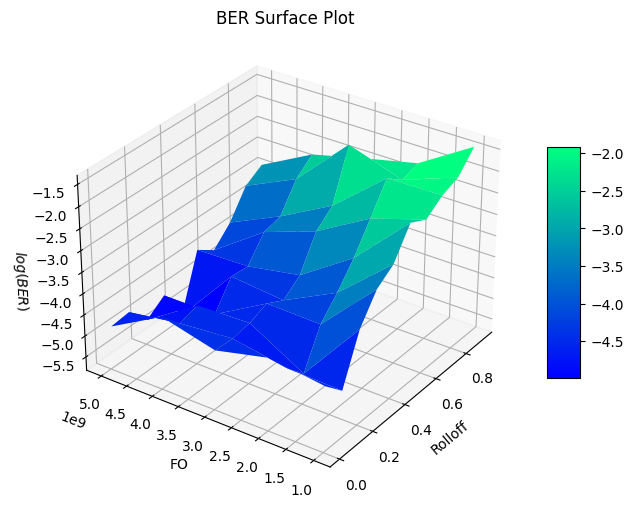

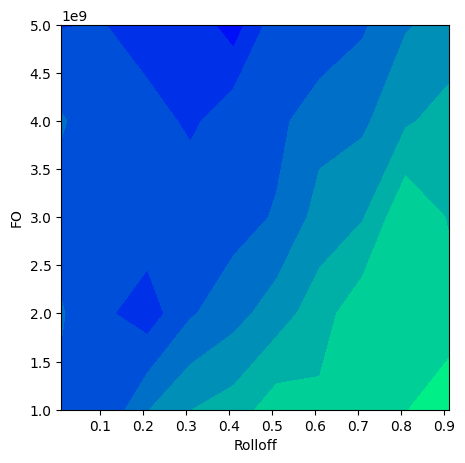

<Figure size 640x480 with 0 Axes>

In [96]:
x = np.arange(0.01, 0.99, 0.1)
y = np.arange(1e9, 6e9, 1e9)

x, y = np.meshgrid(x, y)
z1 = np.log10(BER_NN)  # shape((5, 10))

fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')

fig = plt.figure(figsize=(5, 5))
plt.contourf(x, y, z1, cmap=cm.winter)
plt.xlabel('Rolloff')
plt.ylabel('FO')
plt.savefig(r'C:\Users\Silas\Documents\PIVIC-Comunicacoes-Opticas\resultados\results_ModelPerformanceContourf_64QAM.png', dpi=600)

surf = ax.plot_surface(x, y, z1, cmap=cm.winter, linewidth=1, antialiased=True, edgecolor='None')
#surf = ax.scatter(x, y, z1, marker='s', s=150, color='blue')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=7)
ax.set_xlabel('Rolloff')
ax.set_ylabel('FO')
ax.set_zlabel('$log(BER)$')
ax.view_init(elev=30, azim=215)
ax.set_title('BER Surface Plot')

plt.show()
plt.savefig(r'C:\Users\Silas\Documents\PIVIC-Comunicacoes-Opticas\resultados\results_ModelPerformance_64QAM.png', dpi=600)

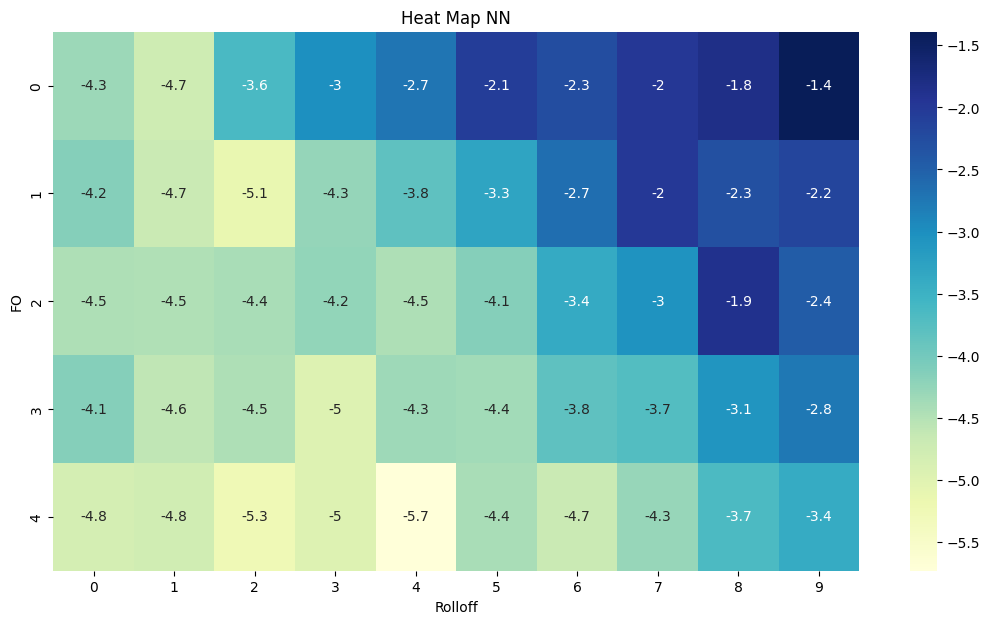

In [134]:
fig = plt.figure(figsize=(13, 7))
sns.heatmap(np.log10(BER_NN), annot=True, cmap='YlGnBu')
plt.title('Heat Map NN')
plt.ylabel('FO')
plt.xlabel('Rolloff')
plt.savefig(r'C:\Users\Silas\Documents\PIVIC-Comunicacoes-Opticas\resultados\results_ModelPerformanceHeatMap_64QAM.png', dpi=600)

In [9]:
## Transmitter parameters:
paramTx = parameters()
paramTx.M = 64                 # order of the modulation format
paramTx.Rs = 32e9              # symbol rate [baud]
paramTx.SpS = 4                # samples per symbol
paramTx.Nbits = 600000         # total number of bits per polarization
paramTx.pulse = "rrc"          # pulse shaping filter
paramTx.Ntaps = 1024           # number of pulse shaping filter coefficients
#paramTx.alphaRRC = 0.91        # RRC rolloff
paramTx.Pch_dBm = 0            # power of the optical signal [dBm]
paramTx.Nch = 1                # number of WDM channels
paramTx.Fc = 193.1e12          # central frequency of the optical spectrum
paramTx.freqSpac = 37.5e9      # WDM grid spacing

## Optical channel parameters:
Ltotal = 50      # total link distance [km]
alpha = 0        # fiber loss parameter [dB/km]
D = 16          # fiber dispersion parameter [ps/nm/km]
Fc = paramTx.Fc  # central optical frequency of the WDM spectrum [Hz]

## Receiver parameters:

# local oscillator (LO)
#FO = 5e9 + paramTx.Rs/2  # frequency offset
lw = 0*200e3       # linewidth
ϕ_lo = 0           # initial phase in rad
Plo_dBm = 12        # power in dBm

# ADC sampling rate
paramADC = parameters()
paramADC.Rs = paramTx.Rs
paramADC.SpS_in = paramTx.SpS
paramADC.SpS_out = 4

## General simulation parameters:
chIndex = 0  # index of the channel to be demodulated
plotPSD = True
Fs = paramTx.Rs * paramTx.SpS  # simulation sampling rate

In [10]:
FO_Values = np.arange(1e9, 6e9, 1e9)
Rolloff = np.arange(0.01, 0.99, 0.1)

BER_KK = np.zeros((FO_Values.size, Rolloff.size))
SER_KK = np.zeros((FO_Values.size, Rolloff.size))
GMI_KK = np.zeros((FO_Values.size, Rolloff.size))
MI_KK  = np.zeros((FO_Values.size, Rolloff.size))
SNR_KK = np.zeros((FO_Values.size, Rolloff.size))

iterations = 5 # number of iterations per simulation

for indfile in range(0, iterations):
    for indNN, FO_ in enumerate(FO_Values):
        for index, indRoll_ in enumerate(Rolloff):
            # Main simulation parameters
            paramTx.alphaRRC = indRoll_
            FO = FO_ + paramTx.Rs/2
            
            # generate optical signal signal
            sigTx, symbTx_, paramTx = simpleWDMTx(paramTx)

            # simulate linear signal propagation
            sigCh = linFiberCh(sigTx, Ltotal, alpha, D, Fc, Fs)

            # receiver detection and demodulation
            Fc = paramTx.Fc
            Ts = 1 / Fs
            mod = QAMModem(m=paramTx.M)

            freqGrid = paramTx.freqGrid
            print(
                "Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n"
                % (
                    chIndex,
                    (Fc + freqGrid[chIndex]) / 1e12,
                    const.c / (Fc + freqGrid[chIndex]) / 1e-9,
                )
            )

            symbTx = symbTx_[:, :, chIndex]

            Plo = 10 ** (Plo_dBm / 10) * 1e-3  # power in W

            print(
                "Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz"
                % (Plo_dBm, lw / 1e3, FO / 1e6)
            )

            # generate LO field
            π = np.pi
            t = np.arange(0, len(sigCh))*Ts
            ϕ_pn_lo = phaseNoise(lw, len(sigCh), Ts)

            sigLO = np.sqrt(Plo) * np.exp(-1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))

            # Add LO to the received signal
            sigRx = np.sqrt(Plo) + sigCh * np.exp(1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
            sfm = sigRx.copy()

            print('CSPR = %.2f dB' % (10*np.log10(signal_power(sigLO)/signal_power(sigCh))))

            # ### Phase-retrieval stage

            # In[4]:

            # resampling to ADC sampling rate
            sigCh = resample(sigCh, paramADC)
            sfm = resample(sfm, paramADC)
            newFs = paramADC.SpS_out*paramTx.Rs

            # simulate ideal direct-detection optical receiver
            Amp = np.abs(sigRx)
            Amp = resample(Amp, paramADC)

            # Kramers-Kronig phase-retrieval
            phiTime = KramersKronigRx(Amp, newFs)

            # optical field reconstruction
            sigRx = Amp*np.exp(1j*phiTime)

            # remove DC level
            sigRx -= np.sqrt(Plo)  # np.mean(sigRx)

            # downshift to baseband
            t = np.arange(0, len(sigRx))*(1/newFs)
            sigRx *= np.exp(-1j * (2 * π * FO * t))

            # correct for (possible) phase ambiguity
            rot = np.mean(sigCh/sigRx)
            sigRx = rot * sigRx
            sigRx = sigRx / np.sqrt(signal_power(sigRx))

            # #### Standard receiver processing

            # In[5]:

            # resample to 2 samples/symbol:
            paramRes = parameters()
            paramRes.Rs = paramTx.Rs
            paramRes.SpS_in = paramADC.SpS_out
            paramRes.SpS_out = 2

            sigRx = resample(sigRx, paramRes)

            # Matched filtering and CD compensation

            # Matched filtering
            if paramTx.pulse == "nrz":
                pulse = pulseShape("nrz", paramADC.SpS_out)
            elif paramTx.pulse == "rrc":
                pulse = pulseShape("rrc", paramRes.SpS_out, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1 / paramTx.Rs)

            pulse = pulse / np.max(np.abs(pulse))
            sigRx = firFilter(pulse, sigRx)

            # plot constellations after matched filtering
            #pconst(sigRx[0::paramRes.SpS_out], lim=True, R=3)

            # CD compensation
            sigRx = edc(sigRx, Ltotal, D, Fc, paramRes.SpS_out*paramTx.Rs)

            #plot constellations after CD compensation
            #pconst(sigRx[0::paramRes.SpS_out], lim=True, R=2)

            # Downsampling to 2 sps and re-synchronization with transmitted sequences
            sigRx = sigRx.reshape(-1, 1)

            symbRx = symbolSync(sigRx, symbTx, 2)

            # In[6]:

            # Power normalization
            x = sigRx
            d = symbRx

            x = x.reshape(len(x), 1) / np.sqrt(signal_power(x))
            d = d.reshape(len(d), 1) / np.sqrt(signal_power(d))

            # Adaptive equalization
            mod = QAMModem(m=paramTx.M)

            paramEq = parameters()
            paramEq.nTaps = 15
            paramEq.SpS = 2
            paramEq.mu = [5e-3, 2e-3]
            paramEq.numIter = 5
            paramEq.storeCoeff = False
            paramEq.alg = ["nlms", "dd-lms"]
            paramEq.M = paramTx.M
            paramEq.L = [20000, 80000]

            y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(x, dx=d, paramEq=paramEq)

            discard = int(paramEq.L[0]/2)

            #plot constellations after adaptive equalization
            #pconst(y_EQ[discard:-discard, :], lim=True)

            # In[7]:

            # Carrier phase recovery
            paramCPR = parameters()
            paramCPR.alg = "bps"
            paramCPR.M = paramTx.M
            paramCPR.N = 75
            paramCPR.B = 64
            paramCPR.pilotInd = np.arange(0, len(y_EQ), 20)

            y_CPR, θ = cpr(y_EQ, symbTx=d, paramCPR=paramCPR)

            y_CPR = y_CPR / np.sqrt(signal_power(y_CPR))

            discard = 5000

            # plot constellations after CPR
            #pconst(y_CPR[discard:-discard, :], lim=True)

            # #### Evaluate transmission metrics

            # In[8]:

            # correct for (possible) phase ambiguity
            for k in range(y_CPR.shape[1]):
                rot = np.mean(d[:, k] / y_CPR[:, k])
                y_CPR[:, k] = rot * y_CPR[:, k]

            y_CPR = y_CPR / np.sqrt(signal_power(y_CPR))

            ind = np.arange(discard, d.shape[0] - discard)
            BER_KK[indNN][index], SER_KK[indNN][index], SNR_KK[indNN][index] = fastBERcalc(y_CPR[ind, :], d[ind, :], mod)
            GMI_KK[indNN][index], _ = monteCarloGMI(y_CPR[ind, :], d[ind, :], mod)
            MI_KK[indNN][index] = monteCarloMI(y_CPR[ind, :], d[ind, :], mod)

            print("Results:\n")
            print("SER: %.2e" % (SER_KK[indNN][index]))
            print("BER: %.2e" % (BER_KK[indNN][index]))
            print("SNR: %.2f dB" % (SNR_KK[indNN][index]))
            print("MI: %.2f bits" % (MI_KK[indNN][index]))
            print("GMI: %.2f bits" % (GMI_KK[indNN][index]))

    np.save(r'/home/silas/Documentos/GitHub/PIVIC-Comunicacoes-Opticas/resultados/BER_KK_'+str(indfile), BER_KK)

channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.022355.
nlms pre-convergence training iteration #1
nlms MSE = 0.002423.
nlms pre-convergence training iteration #2
nlms MSE = 0.002021.
nlms pre-convergence training iteration #3
nlms MSE = 0.001792.
nlms pre-convergence training iteration #4
nlms MSE = 0.001638.


dd-lms - training stage #1
dd-lms MSE = 0.000989.
Results:

SER: 3.89e-04
BER: 6.85e-05
SNR: 29.80 dB
MI: 5.99 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.020086.
nlms pre-convergence training iteration #1
nlms MSE = 0.002555.
nlms pre-convergence training iteration #2
nlms MSE = 0.002080.
nlms pre-convergence training iteration #3
nlms MSE = 0.001835.
nlms pre-convergence training iteration #4
nlms MSE = 0.001686.


dd-lms - training stage #1
dd-lms MSE = 0.001172.
Results:

SER: 4.22e-04
BER: 7.04e-05
SNR: 29.19 dB
MI: 5.99 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.022567.
nlms pre-convergence training iteration #1
nlms MSE = 0.005585.
nlms pre-convergence training iteration #2
nlms MSE = 0.004895.
nlms pre-convergence training iteration #3
nlms MSE = 0.004512.
nlms pre-convergence training iteration #4
nlms MSE = 0.004258.


dd-lms - training stage #1
dd-lms MSE = 0.002996.
Results:

SER: 2.00e-03
BER: 3.37e-04
SNR: 25.18 dB
MI: 5.98 bits
GMI: 5.98 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.027478.
nlms pre-convergence training iteration #1
nlms MSE = 0.008801.
nlms pre-convergence training iteration #2
nlms MSE = 0.007281.
nlms pre-convergence training iteration #3
nlms MSE = 0.006488.
nlms pre-convergence training iteration #4
nlms MSE = 0.005983.


dd-lms - training stage #1
dd-lms MSE = 0.004025.
Results:

SER: 6.49e-03
BER: 1.10e-03
SNR: 23.85 dB
MI: 5.96 bits
GMI: 5.96 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.032747.
nlms pre-convergence training iteration #1
nlms MSE = 0.011512.
nlms pre-convergence training iteration #2
nlms MSE = 0.009178.
nlms pre-convergence training iteration #3
nlms MSE = 0.008067.
nlms pre-convergence training iteration #4
nlms MSE = 0.007396.


dd-lms - training stage #1
dd-lms MSE = 0.005242.
Results:

SER: 1.60e-02
BER: 2.71e-03
SNR: 22.58 dB
MI: 5.92 bits
GMI: 5.91 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.037569.
nlms pre-convergence training iteration #1
nlms MSE = 0.014166.
nlms pre-convergence training iteration #2
nlms MSE = 0.011178.
nlms pre-convergence training iteration #3
nlms MSE = 0.009804.
nlms pre-convergence training iteration #4
nlms MSE = 0.008984.


dd-lms - training stage #1
dd-lms MSE = 0.006579.
Results:

SER: 2.97e-02
BER: 5.11e-03
SNR: 21.47 dB
MI: 5.86 bits
GMI: 5.85 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.044305.
nlms pre-convergence training iteration #1
nlms MSE = 0.017713.
nlms pre-convergence training iteration #2
nlms MSE = 0.014048.
nlms pre-convergence training iteration #3
nlms MSE = 0.012371.
nlms pre-convergence training iteration #4
nlms MSE = 0.011376.


dd-lms - training stage #1
dd-lms MSE = 0.008030.
Results:

SER: 5.45e-02
BER: 9.37e-03
SNR: 20.36 dB
MI: 5.75 bits
GMI: 5.75 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.051197.
nlms pre-convergence training iteration #1
nlms MSE = 0.021852.
nlms pre-convergence training iteration #2
nlms MSE = 0.017443.
nlms pre-convergence training iteration #3
nlms MSE = 0.015398.
nlms pre-convergence training iteration #4
nlms MSE = 0.014181.


dd-lms - training stage #1
dd-lms MSE = 0.009216.
Results:

SER: 7.97e-02
BER: 1.37e-02
SNR: 19.52 dB
MI: 5.65 bits
GMI: 5.65 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.057285.
nlms pre-convergence training iteration #1
nlms MSE = 0.025676.
nlms pre-convergence training iteration #2
nlms MSE = 0.020437.
nlms pre-convergence training iteration #3
nlms MSE = 0.017989.
nlms pre-convergence training iteration #4
nlms MSE = 0.016516.


dd-lms - training stage #1
dd-lms MSE = 0.010685.
Results:

SER: 1.18e-01
BER: 2.06e-02
SNR: 18.57 dB
MI: 5.49 bits
GMI: 5.49 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.064470.
nlms pre-convergence training iteration #1
nlms MSE = 0.029339.
nlms pre-convergence training iteration #2
nlms MSE = 0.023385.
nlms pre-convergence training iteration #3
nlms MSE = 0.020629.
nlms pre-convergence training iteration #4
nlms MSE = 0.018965.


dd-lms - training stage #1
dd-lms MSE = 0.011786.
Results:

SER: 1.60e-01
BER: 2.83e-02
SNR: 17.75 dB
MI: 5.32 bits
GMI: 5.32 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.022388.
nlms pre-convergence training iteration #1
nlms MSE = 0.002423.
nlms pre-convergence training iteration #2
nlms MSE = 0.002011.
nlms pre-convergence training iteration #3
nlms MSE = 0.001775.
nlms pre-convergence training iteration #4
nlms MSE = 0.001621.


dd-lms - training stage #1
dd-lms MSE = 0.001101.
Results:

SER: 4.89e-04
BER: 8.52e-05
SNR: 29.35 dB
MI: 5.99 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.019749.
nlms pre-convergence training iteration #1
nlms MSE = 0.002527.
nlms pre-convergence training iteration #2
nlms MSE = 0.002072.
nlms pre-convergence training iteration #3
nlms MSE = 0.001832.
nlms pre-convergence training iteration #4
nlms MSE = 0.001683.


dd-lms - training stage #1
dd-lms MSE = 0.001009.
Results:

SER: 4.67e-04
BER: 7.78e-05
SNR: 29.73 dB
MI: 5.99 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.017503.
nlms pre-convergence training iteration #1
nlms MSE = 0.002743.
nlms pre-convergence training iteration #2
nlms MSE = 0.002532.
nlms pre-convergence training iteration #3
nlms MSE = 0.002391.
nlms pre-convergence training iteration #4
nlms MSE = 0.002291.


dd-lms - training stage #1
dd-lms MSE = 0.001443.
Results:

SER: 4.67e-04
BER: 8.15e-05
SNR: 28.33 dB
MI: 5.99 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.020172.
nlms pre-convergence training iteration #1
nlms MSE = 0.004955.
nlms pre-convergence training iteration #2
nlms MSE = 0.004375.
nlms pre-convergence training iteration #3
nlms MSE = 0.003988.
nlms pre-convergence training iteration #4
nlms MSE = 0.003708.


dd-lms - training stage #1
dd-lms MSE = 0.002310.
Results:

SER: 9.67e-04
BER: 1.65e-04
SNR: 26.28 dB
MI: 5.99 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.024193.
nlms pre-convergence training iteration #1
nlms MSE = 0.007527.
nlms pre-convergence training iteration #2
nlms MSE = 0.005975.
nlms pre-convergence training iteration #3
nlms MSE = 0.005162.
nlms pre-convergence training iteration #4
nlms MSE = 0.004671.


dd-lms - training stage #1
dd-lms MSE = 0.003084.
Results:

SER: 2.63e-03
BER: 4.46e-04
SNR: 25.01 dB
MI: 5.98 bits
GMI: 5.98 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.028951.
nlms pre-convergence training iteration #1
nlms MSE = 0.009673.
nlms pre-convergence training iteration #2
nlms MSE = 0.007456.
nlms pre-convergence training iteration #3
nlms MSE = 0.006457.
nlms pre-convergence training iteration #4
nlms MSE = 0.005901.


dd-lms - training stage #1
dd-lms MSE = 0.004229.
Results:

SER: 7.41e-03
BER: 1.25e-03
SNR: 23.65 dB
MI: 5.96 bits
GMI: 5.95 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.033984.
nlms pre-convergence training iteration #1
nlms MSE = 0.012341.
nlms pre-convergence training iteration #2
nlms MSE = 0.009448.
nlms pre-convergence training iteration #3
nlms MSE = 0.008214.
nlms pre-convergence training iteration #4
nlms MSE = 0.007533.


dd-lms - training stage #1
dd-lms MSE = 0.005502.
Results:

SER: 1.70e-02
BER: 2.88e-03
SNR: 22.38 dB
MI: 5.91 bits
GMI: 5.91 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.039736.
nlms pre-convergence training iteration #1
nlms MSE = 0.015273.
nlms pre-convergence training iteration #2
nlms MSE = 0.011798.
nlms pre-convergence training iteration #3
nlms MSE = 0.010320.
nlms pre-convergence training iteration #4
nlms MSE = 0.009486.


dd-lms - training stage #1
dd-lms MSE = 0.006779.
Results:

SER: 3.24e-02
BER: 5.53e-03
SNR: 21.29 dB
MI: 5.84 bits
GMI: 5.84 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.045702.
nlms pre-convergence training iteration #1
nlms MSE = 0.018905.
nlms pre-convergence training iteration #2
nlms MSE = 0.014822.
nlms pre-convergence training iteration #3
nlms MSE = 0.013013.
nlms pre-convergence training iteration #4
nlms MSE = 0.011958.


dd-lms - training stage #1
dd-lms MSE = 0.008062.
Results:

SER: 5.43e-02
BER: 9.35e-03
SNR: 20.30 dB
MI: 5.75 bits
GMI: 5.75 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.051931.
nlms pre-convergence training iteration #1
nlms MSE = 0.022429.
nlms pre-convergence training iteration #2
nlms MSE = 0.017659.
nlms pre-convergence training iteration #3
nlms MSE = 0.015517.
nlms pre-convergence training iteration #4
nlms MSE = 0.014253.


dd-lms - training stage #1
dd-lms MSE = 0.009448.
Results:

SER: 8.25e-02
BER: 1.42e-02
SNR: 19.41 dB
MI: 5.64 bits
GMI: 5.64 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.022325.
nlms pre-convergence training iteration #1
nlms MSE = 0.002652.
nlms pre-convergence training iteration #2
nlms MSE = 0.002258.
nlms pre-convergence training iteration #3
nlms MSE = 0.002033.
nlms pre-convergence training iteration #4
nlms MSE = 0.001884.


dd-lms - training stage #1
dd-lms MSE = 0.001265.
Results:

SER: 6.67e-04
BER: 1.13e-04
SNR: 28.80 dB
MI: 5.99 bits
GMI: 5.98 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.020430.
nlms pre-convergence training iteration #1
nlms MSE = 0.002579.
nlms pre-convergence training iteration #2
nlms MSE = 0.002115.
nlms pre-convergence training iteration #3
nlms MSE = 0.001869.
nlms pre-convergence training iteration #4
nlms MSE = 0.001717.


dd-lms - training stage #1
dd-lms MSE = 0.001164.
Results:

SER: 7.11e-04
BER: 1.24e-04
SNR: 29.13 dB
MI: 5.99 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.017001.
nlms pre-convergence training iteration #1
nlms MSE = 0.002140.
nlms pre-convergence training iteration #2
nlms MSE = 0.001968.
nlms pre-convergence training iteration #3
nlms MSE = 0.001845.
nlms pre-convergence training iteration #4
nlms MSE = 0.001756.


dd-lms - training stage #1
dd-lms MSE = 0.001252.
Results:

SER: 6.22e-04
BER: 1.04e-04
SNR: 28.85 dB
MI: 5.99 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.016517.
nlms pre-convergence training iteration #1
nlms MSE = 0.002630.
nlms pre-convergence training iteration #2
nlms MSE = 0.002551.
nlms pre-convergence training iteration #3
nlms MSE = 0.002482.
nlms pre-convergence training iteration #4
nlms MSE = 0.002422.


dd-lms - training stage #1
dd-lms MSE = 0.001713.
Results:

SER: 7.78e-04
BER: 1.35e-04
SNR: 27.55 dB
MI: 5.99 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.018663.
nlms pre-convergence training iteration #1
nlms MSE = 0.004795.
nlms pre-convergence training iteration #2
nlms MSE = 0.004213.
nlms pre-convergence training iteration #3
nlms MSE = 0.003808.
nlms pre-convergence training iteration #4
nlms MSE = 0.003511.


dd-lms - training stage #1
dd-lms MSE = 0.002205.
Results:

SER: 1.38e-03
BER: 2.31e-04
SNR: 26.42 dB
MI: 5.99 bits
GMI: 5.98 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.022574.
nlms pre-convergence training iteration #1
nlms MSE = 0.007157.
nlms pre-convergence training iteration #2
nlms MSE = 0.005690.
nlms pre-convergence training iteration #3
nlms MSE = 0.004921.
nlms pre-convergence training iteration #4
nlms MSE = 0.004475.


dd-lms - training stage #1
dd-lms MSE = 0.002905.
Results:

SER: 2.22e-03
BER: 3.72e-04
SNR: 25.29 dB
MI: 5.98 bits
GMI: 5.98 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.026422.
nlms pre-convergence training iteration #1
nlms MSE = 0.008924.
nlms pre-convergence training iteration #2
nlms MSE = 0.006760.
nlms pre-convergence training iteration #3
nlms MSE = 0.005806.
nlms pre-convergence training iteration #4
nlms MSE = 0.005312.


dd-lms - training stage #1
dd-lms MSE = 0.003915.
Results:

SER: 6.13e-03
BER: 1.03e-03
SNR: 23.94 dB
MI: 5.96 bits
GMI: 5.96 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.031111.
nlms pre-convergence training iteration #1
nlms MSE = 0.011100.
nlms pre-convergence training iteration #2
nlms MSE = 0.008469.
nlms pre-convergence training iteration #3
nlms MSE = 0.007411.
nlms pre-convergence training iteration #4
nlms MSE = 0.006854.


dd-lms - training stage #1
dd-lms MSE = 0.005032.
Results:

SER: 1.26e-02
BER: 2.13e-03
SNR: 22.79 dB
MI: 5.93 bits
GMI: 5.93 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.036033.
nlms pre-convergence training iteration #1
nlms MSE = 0.013994.
nlms pre-convergence training iteration #2
nlms MSE = 0.010793.
nlms pre-convergence training iteration #3
nlms MSE = 0.009477.
nlms pre-convergence training iteration #4
nlms MSE = 0.008751.


dd-lms - training stage #1
dd-lms MSE = 0.006283.
Results:

SER: 2.70e-02
BER: 4.65e-03
SNR: 21.65 dB
MI: 5.87 bits
GMI: 5.87 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.041384.
nlms pre-convergence training iteration #1
nlms MSE = 0.016911.
nlms pre-convergence training iteration #2
nlms MSE = 0.013182.
nlms pre-convergence training iteration #3
nlms MSE = 0.011572.
nlms pre-convergence training iteration #4
nlms MSE = 0.010635.


dd-lms - training stage #1
dd-lms MSE = 0.007485.
Results:

SER: 4.46e-02
BER: 7.66e-03
SNR: 20.73 dB
MI: 5.80 bits
GMI: 5.79 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.022253.
nlms pre-convergence training iteration #1
nlms MSE = 0.002784.
nlms pre-convergence training iteration #2
nlms MSE = 0.002373.
nlms pre-convergence training iteration #3
nlms MSE = 0.002137.
nlms pre-convergence training iteration #4
nlms MSE = 0.001982.


dd-lms - training stage #1
dd-lms MSE = 0.001473.
Results:

SER: 9.89e-04
BER: 1.69e-04
SNR: 28.14 dB
MI: 5.98 bits
GMI: 5.98 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.020701.
nlms pre-convergence training iteration #1
nlms MSE = 0.002753.
nlms pre-convergence training iteration #2
nlms MSE = 0.002280.
nlms pre-convergence training iteration #3
nlms MSE = 0.002025.
nlms pre-convergence training iteration #4
nlms MSE = 0.001866.


dd-lms - training stage #1
dd-lms MSE = 0.001357.
Results:

SER: 1.03e-03
BER: 1.74e-04
SNR: 28.46 dB
MI: 5.98 bits
GMI: 5.98 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.017627.
nlms pre-convergence training iteration #1
nlms MSE = 0.002442.
nlms pre-convergence training iteration #2
nlms MSE = 0.002267.
nlms pre-convergence training iteration #3
nlms MSE = 0.002144.
nlms pre-convergence training iteration #4
nlms MSE = 0.002055.


dd-lms - training stage #1
dd-lms MSE = 0.001496.
Results:

SER: 1.07e-03
BER: 1.85e-04
SNR: 28.11 dB
MI: 5.98 bits
GMI: 5.98 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.015609.
nlms pre-convergence training iteration #1
nlms MSE = 0.002177.
nlms pre-convergence training iteration #2
nlms MSE = 0.002142.
nlms pre-convergence training iteration #3
nlms MSE = 0.002110.
nlms pre-convergence training iteration #4
nlms MSE = 0.002081.


dd-lms - training stage #1
dd-lms MSE = 0.001642.
Results:

SER: 1.23e-03
BER: 2.06e-04
SNR: 27.72 dB
MI: 5.98 bits
GMI: 5.98 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.015870.
nlms pre-convergence training iteration #1
nlms MSE = 0.003015.
nlms pre-convergence training iteration #2
nlms MSE = 0.002906.
nlms pre-convergence training iteration #3
nlms MSE = 0.002810.
nlms pre-convergence training iteration #4
nlms MSE = 0.002725.


dd-lms - training stage #1
dd-lms MSE = 0.002032.
Results:

SER: 1.26e-03
BER: 2.09e-04
SNR: 26.76 dB
MI: 5.99 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.018235.
nlms pre-convergence training iteration #1
nlms MSE = 0.005222.
nlms pre-convergence training iteration #2
nlms MSE = 0.004606.
nlms pre-convergence training iteration #3
nlms MSE = 0.004169.
nlms pre-convergence training iteration #4
nlms MSE = 0.003850.


dd-lms - training stage #1
dd-lms MSE = 0.002451.
Results:

SER: 1.94e-03
BER: 3.26e-04
SNR: 25.91 dB
MI: 5.98 bits
GMI: 5.98 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.020907.
nlms pre-convergence training iteration #1
nlms MSE = 0.007075.
nlms pre-convergence training iteration #2
nlms MSE = 0.005676.
nlms pre-convergence training iteration #3
nlms MSE = 0.004901.
nlms pre-convergence training iteration #4
nlms MSE = 0.004445.


dd-lms - training stage #1
dd-lms MSE = 0.003138.
Results:

SER: 3.32e-03
BER: 5.65e-04
SNR: 24.95 dB
MI: 5.98 bits
GMI: 5.97 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.024932.
nlms pre-convergence training iteration #1
nlms MSE = 0.009128.
nlms pre-convergence training iteration #2
nlms MSE = 0.007009.
nlms pre-convergence training iteration #3
nlms MSE = 0.006039.
nlms pre-convergence training iteration #4
nlms MSE = 0.005535.


dd-lms - training stage #1
dd-lms MSE = 0.004164.
Results:

SER: 7.53e-03
BER: 1.27e-03
SNR: 23.71 dB
MI: 5.96 bits
GMI: 5.95 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.028901.
nlms pre-convergence training iteration #1
nlms MSE = 0.011217.
nlms pre-convergence training iteration #2
nlms MSE = 0.008606.
nlms pre-convergence training iteration #3
nlms MSE = 0.007518.
nlms pre-convergence training iteration #4
nlms MSE = 0.006952.


dd-lms - training stage #1
dd-lms MSE = 0.005225.
Results:

SER: 1.45e-02
BER: 2.47e-03
SNR: 22.64 dB
MI: 5.92 bits
GMI: 5.92 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.034274.
nlms pre-convergence training iteration #1
nlms MSE = 0.013618.
nlms pre-convergence training iteration #2
nlms MSE = 0.010402.
nlms pre-convergence training iteration #3
nlms MSE = 0.009093.
nlms pre-convergence training iteration #4
nlms MSE = 0.008386.


dd-lms - training stage #1
dd-lms MSE = 0.006174.
Results:

SER: 2.38e-02
BER: 4.05e-03
SNR: 21.74 dB
MI: 5.88 bits
GMI: 5.88 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.023151.
nlms pre-convergence training iteration #1
nlms MSE = 0.003004.
nlms pre-convergence training iteration #2
nlms MSE = 0.002594.
nlms pre-convergence training iteration #3
nlms MSE = 0.002360.
nlms pre-convergence training iteration #4
nlms MSE = 0.002206.


dd-lms - training stage #1
dd-lms MSE = 0.001705.
Results:

SER: 1.60e-03
BER: 2.80e-04
SNR: 27.48 dB
MI: 5.97 bits
GMI: 5.97 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.020513.
nlms pre-convergence training iteration #1
nlms MSE = 0.002996.
nlms pre-convergence training iteration #2
nlms MSE = 0.002537.
nlms pre-convergence training iteration #3
nlms MSE = 0.002298.
nlms pre-convergence training iteration #4
nlms MSE = 0.002151.


dd-lms - training stage #1
dd-lms MSE = 0.001662.
Results:

SER: 1.61e-03
BER: 2.69e-04
SNR: 27.65 dB
MI: 5.97 bits
GMI: 5.97 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.017889.
nlms pre-convergence training iteration #1
nlms MSE = 0.002803.
nlms pre-convergence training iteration #2
nlms MSE = 0.002618.
nlms pre-convergence training iteration #3
nlms MSE = 0.002486.
nlms pre-convergence training iteration #4
nlms MSE = 0.002389.


dd-lms - training stage #1
dd-lms MSE = 0.001698.
Results:

SER: 1.07e-03
BER: 1.91e-04
SNR: 27.55 dB
MI: 5.98 bits
GMI: 5.98 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.016140.
nlms pre-convergence training iteration #1
nlms MSE = 0.002369.
nlms pre-convergence training iteration #2
nlms MSE = 0.002330.
nlms pre-convergence training iteration #3
nlms MSE = 0.002296.
nlms pre-convergence training iteration #4
nlms MSE = 0.002266.


dd-lms - training stage #1
dd-lms MSE = 0.001868.
Results:

SER: 1.50e-03
BER: 2.57e-04
SNR: 27.16 dB
MI: 5.98 bits
GMI: 5.98 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.015163.
nlms pre-convergence training iteration #1
nlms MSE = 0.002665.
nlms pre-convergence training iteration #2
nlms MSE = 0.002625.
nlms pre-convergence training iteration #3
nlms MSE = 0.002587.
nlms pre-convergence training iteration #4
nlms MSE = 0.002552.


dd-lms - training stage #1
dd-lms MSE = 0.002030.
Results:

SER: 1.46e-03
BER: 2.46e-04
SNR: 26.76 dB
MI: 5.98 bits
GMI: 5.98 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.015881.
nlms pre-convergence training iteration #1
nlms MSE = 0.003771.
nlms pre-convergence training iteration #2
nlms MSE = 0.003623.
nlms pre-convergence training iteration #3
nlms MSE = 0.003493.
nlms pre-convergence training iteration #4
nlms MSE = 0.003378.


dd-lms - training stage #1
dd-lms MSE = 0.002389.
Results:

SER: 2.07e-03
BER: 3.46e-04
SNR: 25.97 dB
MI: 5.98 bits
GMI: 5.98 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.017207.
nlms pre-convergence training iteration #1
nlms MSE = 0.005417.
nlms pre-convergence training iteration #2
nlms MSE = 0.004832.
nlms pre-convergence training iteration #3
nlms MSE = 0.004415.
nlms pre-convergence training iteration #4
nlms MSE = 0.004111.


dd-lms - training stage #1
dd-lms MSE = 0.002925.
Results:

SER: 3.44e-03
BER: 5.81e-04
SNR: 25.17 dB
MI: 5.98 bits
GMI: 5.97 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.020192.
nlms pre-convergence training iteration #1
nlms MSE = 0.007431.
nlms pre-convergence training iteration #2
nlms MSE = 0.006160.
nlms pre-convergence training iteration #3
nlms MSE = 0.005434.
nlms pre-convergence training iteration #4
nlms MSE = 0.004997.


dd-lms - training stage #1
dd-lms MSE = 0.003536.
Results:

SER: 4.96e-03
BER: 8.52e-04
SNR: 24.34 dB
MI: 5.96 bits
GMI: 5.96 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.023349.
nlms pre-convergence training iteration #1
nlms MSE = 0.009364.
nlms pre-convergence training iteration #2
nlms MSE = 0.007458.
nlms pre-convergence training iteration #3
nlms MSE = 0.006554.
nlms pre-convergence training iteration #4
nlms MSE = 0.006074.


dd-lms - training stage #1
dd-lms MSE = 0.004464.
Results:

SER: 9.12e-03
BER: 1.54e-03
SNR: 23.33 dB
MI: 5.94 bits
GMI: 5.94 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.027279.
nlms pre-convergence training iteration #1
nlms MSE = 0.011035.
nlms pre-convergence training iteration #2
nlms MSE = 0.008601.
nlms pre-convergence training iteration #3
nlms MSE = 0.007574.
nlms pre-convergence training iteration #4
nlms MSE = 0.007038.


dd-lms - training stage #1
dd-lms MSE = 0.005424.
Results:

SER: 1.51e-02
BER: 2.56e-03
SNR: 22.43 dB
MI: 5.92 bits
GMI: 5.92 bits


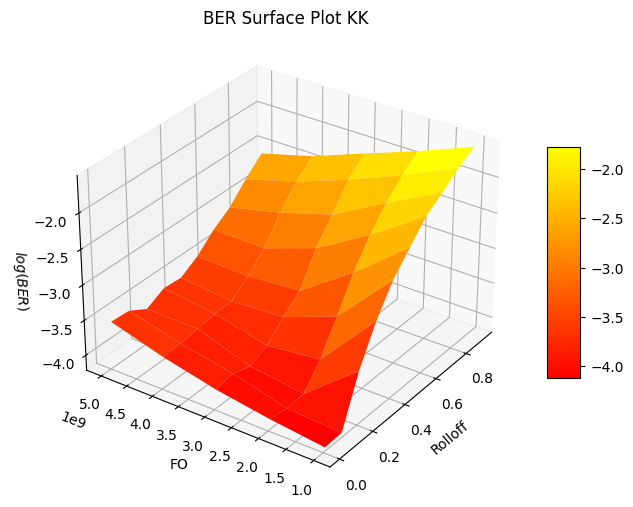

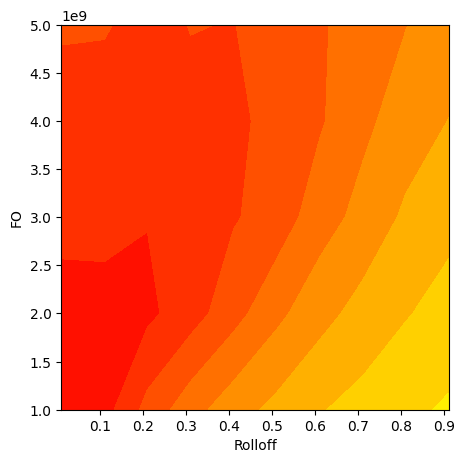

<Figure size 640x480 with 0 Axes>

In [94]:
x = np.arange(0.01, 0.99, 0.1)
y = np.arange(1e9, 6e9, 1e9)

x, y = np.meshgrid(x, y)
z1 = np.log10(BER_KK)  # shape((5, 10))

fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')

fig = plt.figure(figsize=(5, 5))
plt.contourf(x, y, z1, cmap=cm.autumn)
plt.xlabel('Rolloff')
plt.ylabel('FO')
plt.savefig(r'C:\Users\Silas\Documents\PIVIC-Comunicacoes-Opticas\resultados\results_KKPerformanceContourf_64QAM.png', dpi=600)

surf_KK = ax.plot_surface(x, y, z1, cmap=cm.autumn, linewidth=1, antialiased=True, edgecolor='None')
#surf_KK = ax.scatter(x, y, z1, marker='s', s=200, color='blue')
fig.colorbar(surf_KK, ax=ax, shrink=0.5, aspect=7)
ax.set_xlabel('Rolloff')
ax.set_ylabel('FO')
ax.set_zlabel('$log(BER)$')
ax.view_init(elev=30, azim=215)
ax.set_title('BER Surface Plot KK')

plt.show()
plt.savefig(r'C:\Users\Silas\Documents\PIVIC-Comunicacoes-Opticas\resultados\results_KKPerformance_64QAM.png', dpi=600)


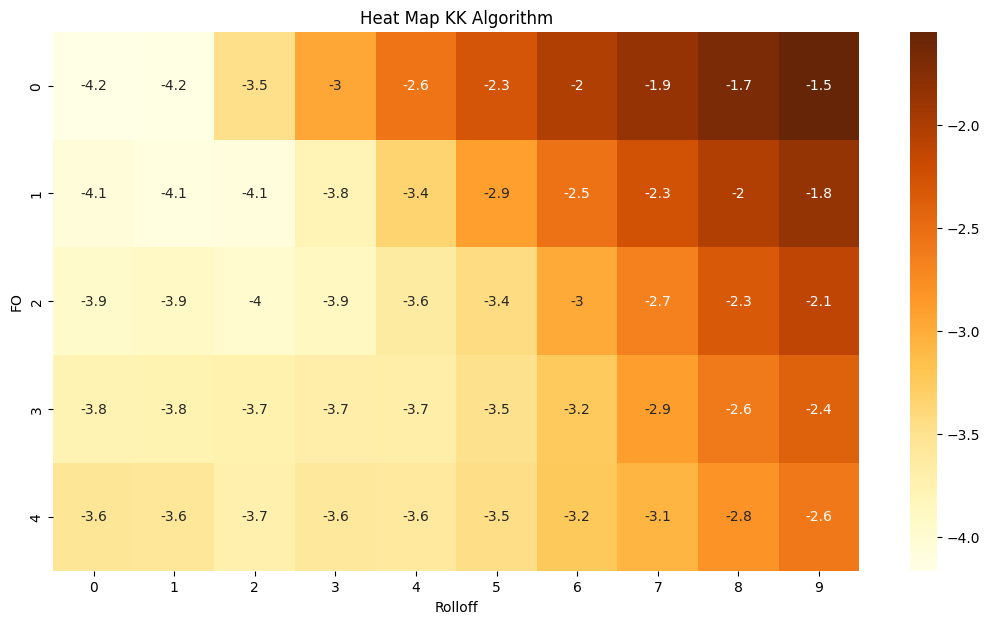

In [133]:
fig = plt.figure(figsize=(13, 7))
sns.heatmap(np.log10(BER_KK), annot=True, cmap='YlOrBr')
plt.title('Heat Map KK Algorithm')
plt.ylabel('FO')
plt.xlabel('Rolloff')
plt.savefig(r'C:\Users\Silas\Documents\PIVIC-Comunicacoes-Opticas\resultados\results_KKPerformanceHeatMap_64QAM.png', dpi=600);

#### Superposition of Surfaces

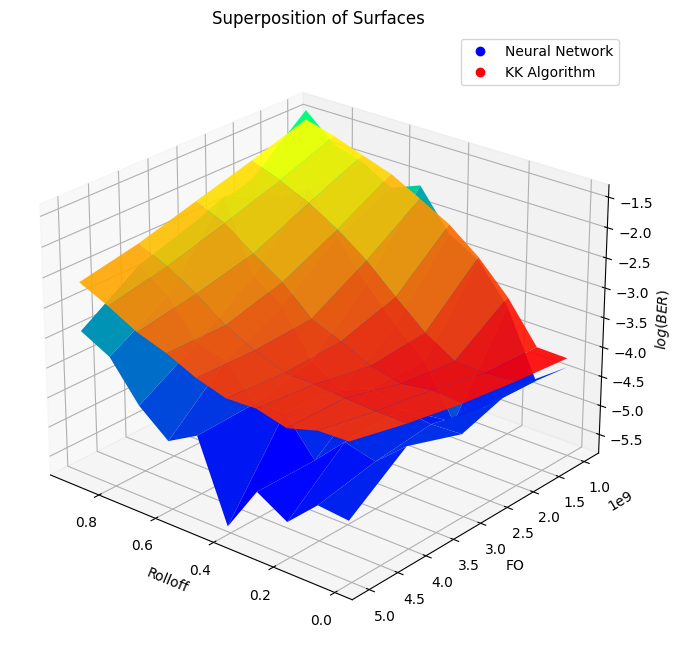

In [113]:
import matplotlib as mpl

x = np.arange(0.01, 0.99, 0.1)
y = np.arange(1e9, 6e9, 1e9)

x, y = np.meshgrid(x, y)
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')

ax.plot_surface(x, y, np.log10(BER_NN), label='teste',alpha = 1, rstride=1, cstride=1, cmap=cm.winter, linewidth=0.5, antialiased=True, zorder = 0.5)
ax.plot_surface(x, y, np.log10(BER_KK), alpha = 0.90, rstride=1, cstride=1, cmap=cm.autumn, linewidth=0.5, antialiased=True, zorder = 0.3)
ax.set_title('Superposition of Surfaces')
ax.set_xlabel('Rolloff')
ax.set_ylabel('FO')
ax.set_zlabel('$log(BER)$')
ax.view_init(elev=25, azim=130)

# fake legends
fake2Dline = mpl.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
fake2Dline2 = mpl.lines.Line2D([0],[0], linestyle="none", c='r', marker = 'o')
ax.legend([fake2Dline, fake2Dline2], ['Neural Network', 'KK Algorithm'], numpoints = 1)

plt.savefig(r'C:\Users\Silas\Documents\PIVIC-Comunicacoes-Opticas\resultados\results_SuperpositionSurfaces_64QAM.png', dpi=600)
